In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2017791077311023893, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14450031014294794741
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6912780737520207718
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15884438733
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 362047958909962457
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.applications.vgg19 import VGG19
from keras.regularizers import l2, l1

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.13.1


In [5]:
batch_size = 32
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
print(os.listdir("../input/aptos-binary-noaug/aptos_binary/APTOS_Binary/"))

['train', 'test']


In [7]:
train_dir = '../input/aptos-binary-noaug/aptos_binary/APTOS_Binary/train/'
test_dir = '../input/aptos-binary-noaug/aptos_binary/APTOS_Binary/test/'

In [8]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
#     zoom_range=0.2,
#     shear_range=0.2,
    validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 2656 images belonging to 2 classes.
Found 663 images belonging to 2 classes.
Found 343 images belonging to 2 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 2656
nb_validation_samples: 663
nb_test_samples: 343

predict_size_train: 83
predict_size_validation: 21
predict_size_test: 11

 num_classes: 2


In [19]:
os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "MobileNet_descriptors"

In [20]:
vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
xception_weights = "../input/full-keras-pretrained-no-top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [21]:
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
from keras.applications import DenseNet121
from keras.applications import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import NASNetLarge, NASNetMobile
from keras.applications import MobileNet

In [22]:
input_tensor = Input(shape = input_shape)  

base_model1=DenseNet121(weights=denseNet121_weights, include_top=False, pooling = "avg", input_tensor = input_tensor )
# base_model2=Xception(input_shape= input_shape,weights=xception_weights, include_top=False, input_tensor=input_tensor)

# x1 = base_model1.output
# x1 = GlobalAveragePooling2D()(x1)

# x2 = base_model2.output
# x2 = GlobalAveragePooling2D()(x2)

# merge = concatenate([x1, x2])
# predictions = Dense(num_classes, activation='softmax')(merge)

# model = Model(inputs=input_tensor,outputs=predictions)

In [23]:
base_model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [24]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [25]:
bottleneck_final_model = base_model1

In [26]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [27]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [28]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [29]:

# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))

# reset_keras_tf_session()

In [30]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [31]:
adam_opt=Adam(lr=0.0001, beta_1=0.8, beta_2=0.9)
dropout_rate = 0.5

model = Sequential()
model.add(Dense(4096, activation="elu", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.1), activity_regularizer=l1(1e-05)))
model.add(Dropout(dropout_rate))

model.add(Dense(256, activation="elu", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.1), activity_regularizer=l1(1e-05)))
model.add(Dropout(dropout_rate))

model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)


Train on 2656 samples, validate on 663 samples
Epoch 1/1000
 - 6s - loss: 0.7857 - acc: 0.8622 - val_loss: 0.4677 - val_acc: 0.9623
Epoch 2/1000
 - 1s - loss: 0.5922 - acc: 0.9164 - val_loss: 0.3919 - val_acc: 0.9668
Epoch 3/1000
 - 1s - loss: 0.5192 - acc: 0.9322 - val_loss: 0.3580 - val_acc: 0.9713
Epoch 4/1000
 - 1s - loss: 0.5047 - acc: 0.9266 - val_loss: 0.3472 - val_acc: 0.9713
Epoch 5/1000
 - 1s - loss: 0.4947 - acc: 0.9337 - val_loss: 0.3740 - val_acc: 0.9713
Epoch 6/1000
 - 1s - loss: 0.4681 - acc: 0.9341 - val_loss: 0.3352 - val_acc: 0.9713
Epoch 7/1000
 - 1s - loss: 0.4711 - acc: 0.9319 - val_loss: 0.3463 - val_acc: 0.9683
Epoch 8/1000
 - 1s - loss: 0.4657 - acc: 0.9288 - val_loss: 0.3207 - val_acc: 0.9744
Epoch 9/1000
 - 1s - loss: 0.4595 - acc: 0.9281 - val_loss: 0.3200 - val_acc: 0.9729
Epoch 10/1000
 - 1s - loss: 0.4559 - acc: 0.9360 - val_loss: 0.3166 - val_acc: 0.9729
Epoch 11/1000
 - 1s - loss: 0.4216 - acc: 0.9439 - val_loss: 0.3163 - val_acc: 0.9729
Epoch 12/1000
 -

Epoch 96/1000
 - 1s - loss: 0.2765 - acc: 0.9631 - val_loss: 0.2849 - val_acc: 0.9623
Epoch 97/1000
 - 1s - loss: 0.2769 - acc: 0.9631 - val_loss: 0.3079 - val_acc: 0.9472
Epoch 98/1000
 - 1s - loss: 0.2633 - acc: 0.9657 - val_loss: 0.3080 - val_acc: 0.9502
Epoch 99/1000
 - 1s - loss: 0.2661 - acc: 0.9639 - val_loss: 0.2845 - val_acc: 0.9578
Epoch 100/1000
 - 1s - loss: 0.2709 - acc: 0.9601 - val_loss: 0.2853 - val_acc: 0.9623
Epoch 101/1000
 - 1s - loss: 0.2687 - acc: 0.9642 - val_loss: 0.2943 - val_acc: 0.9578
Epoch 102/1000
 - 1s - loss: 0.2591 - acc: 0.9676 - val_loss: 0.2884 - val_acc: 0.9608
Epoch 103/1000
 - 1s - loss: 0.2732 - acc: 0.9605 - val_loss: 0.2836 - val_acc: 0.9623
Epoch 104/1000
 - 1s - loss: 0.2745 - acc: 0.9590 - val_loss: 0.2871 - val_acc: 0.9623
Epoch 105/1000
 - 1s - loss: 0.2792 - acc: 0.9605 - val_loss: 0.2800 - val_acc: 0.9623
Epoch 106/1000
 - 1s - loss: 0.2721 - acc: 0.9605 - val_loss: 0.2807 - val_acc: 0.9623
Epoch 107/1000
 - 1s - loss: 0.2687 - acc: 0.96

Epoch 191/1000
 - 1s - loss: 0.2059 - acc: 0.9797 - val_loss: 0.3424 - val_acc: 0.9532
Epoch 192/1000
 - 1s - loss: 0.2065 - acc: 0.9819 - val_loss: 0.3528 - val_acc: 0.9367
Epoch 193/1000
 - 1s - loss: 0.2176 - acc: 0.9759 - val_loss: 0.3684 - val_acc: 0.9397
Epoch 194/1000
 - 1s - loss: 0.2107 - acc: 0.9789 - val_loss: 0.3282 - val_acc: 0.9532
Epoch 195/1000
 - 1s - loss: 0.2081 - acc: 0.9816 - val_loss: 0.3295 - val_acc: 0.9532
Epoch 196/1000
 - 1s - loss: 0.2017 - acc: 0.9789 - val_loss: 0.3475 - val_acc: 0.9502
Epoch 197/1000
 - 1s - loss: 0.1965 - acc: 0.9823 - val_loss: 0.3694 - val_acc: 0.9548
Epoch 198/1000
 - 1s - loss: 0.2076 - acc: 0.9804 - val_loss: 0.3261 - val_acc: 0.9532
Epoch 199/1000
 - 1s - loss: 0.2201 - acc: 0.9789 - val_loss: 0.3294 - val_acc: 0.9563
Epoch 200/1000
 - 1s - loss: 0.2030 - acc: 0.9800 - val_loss: 0.3432 - val_acc: 0.9397
Epoch 201/1000
 - 1s - loss: 0.1975 - acc: 0.9834 - val_loss: 0.3723 - val_acc: 0.9502
Epoch 202/1000
 - 1s - loss: 0.2030 - acc: 

 - 1s - loss: 0.1667 - acc: 0.9887 - val_loss: 0.3976 - val_acc: 0.9336
Epoch 286/1000
 - 1s - loss: 0.1676 - acc: 0.9876 - val_loss: 0.3972 - val_acc: 0.9457
Epoch 287/1000
 - 1s - loss: 0.1643 - acc: 0.9910 - val_loss: 0.4228 - val_acc: 0.9427
Epoch 288/1000
 - 1s - loss: 0.1693 - acc: 0.9906 - val_loss: 0.3934 - val_acc: 0.9457
Epoch 289/1000
 - 1s - loss: 0.1798 - acc: 0.9891 - val_loss: 0.4712 - val_acc: 0.9321
Epoch 290/1000
 - 1s - loss: 0.1706 - acc: 0.9902 - val_loss: 0.3557 - val_acc: 0.9472
Epoch 291/1000
 - 1s - loss: 0.1671 - acc: 0.9883 - val_loss: 0.3558 - val_acc: 0.9472
Epoch 292/1000
 - 1s - loss: 0.1595 - acc: 0.9921 - val_loss: 0.3605 - val_acc: 0.9442
Epoch 293/1000
 - 1s - loss: 0.1740 - acc: 0.9857 - val_loss: 0.4331 - val_acc: 0.9427
Epoch 294/1000
 - 1s - loss: 0.1676 - acc: 0.9913 - val_loss: 0.4143 - val_acc: 0.9412
Epoch 295/1000
 - 1s - loss: 0.1594 - acc: 0.9921 - val_loss: 0.4038 - val_acc: 0.9517
Epoch 296/1000
 - 1s - loss: 0.1794 - acc: 0.9868 - val_lo

Epoch 380/1000
 - 1s - loss: 0.1431 - acc: 0.9936 - val_loss: 0.4081 - val_acc: 0.9382
Epoch 381/1000
 - 1s - loss: 0.1498 - acc: 0.9906 - val_loss: 0.3817 - val_acc: 0.9487
Epoch 382/1000
 - 1s - loss: 0.1518 - acc: 0.9913 - val_loss: 0.3701 - val_acc: 0.9457
Epoch 383/1000
 - 1s - loss: 0.1536 - acc: 0.9917 - val_loss: 0.3682 - val_acc: 0.9442
Epoch 384/1000
 - 1s - loss: 0.1516 - acc: 0.9921 - val_loss: 0.3611 - val_acc: 0.9442
Epoch 385/1000
 - 1s - loss: 0.1379 - acc: 0.9962 - val_loss: 0.4083 - val_acc: 0.9442
Epoch 386/1000
 - 1s - loss: 0.1775 - acc: 0.9861 - val_loss: 0.3922 - val_acc: 0.9487
Epoch 387/1000
 - 1s - loss: 0.1545 - acc: 0.9895 - val_loss: 0.4297 - val_acc: 0.9367
Epoch 388/1000
 - 1s - loss: 0.1517 - acc: 0.9913 - val_loss: 0.4198 - val_acc: 0.9412
Epoch 389/1000
 - 1s - loss: 0.1520 - acc: 0.9925 - val_loss: 0.4014 - val_acc: 0.9427
Epoch 390/1000
 - 1s - loss: 0.1600 - acc: 0.9887 - val_loss: 0.4097 - val_acc: 0.9321
Epoch 391/1000
 - 1s - loss: 0.1555 - acc: 

 - 1s - loss: 0.1367 - acc: 0.9936 - val_loss: 0.3947 - val_acc: 0.9502
Epoch 475/1000
 - 1s - loss: 0.1455 - acc: 0.9902 - val_loss: 0.3847 - val_acc: 0.9472
Epoch 476/1000
 - 1s - loss: 0.1456 - acc: 0.9913 - val_loss: 0.3608 - val_acc: 0.9487
Epoch 477/1000
 - 1s - loss: 0.1468 - acc: 0.9910 - val_loss: 0.3437 - val_acc: 0.9442
Epoch 478/1000
 - 1s - loss: 0.1472 - acc: 0.9925 - val_loss: 0.3911 - val_acc: 0.9457
Epoch 479/1000
 - 1s - loss: 0.1502 - acc: 0.9898 - val_loss: 0.3917 - val_acc: 0.9457
Epoch 480/1000
 - 1s - loss: 0.1377 - acc: 0.9936 - val_loss: 0.3730 - val_acc: 0.9472
Epoch 481/1000
 - 1s - loss: 0.1536 - acc: 0.9876 - val_loss: 0.3970 - val_acc: 0.9487
Epoch 482/1000
 - 1s - loss: 0.1642 - acc: 0.9861 - val_loss: 0.4153 - val_acc: 0.9548
Epoch 483/1000
 - 1s - loss: 0.1568 - acc: 0.9883 - val_loss: 0.3703 - val_acc: 0.9502
Epoch 484/1000
 - 1s - loss: 0.1411 - acc: 0.9925 - val_loss: 0.3941 - val_acc: 0.9502
Epoch 485/1000
 - 1s - loss: 0.1350 - acc: 0.9932 - val_lo

Epoch 569/1000
 - 1s - loss: 0.1281 - acc: 0.9932 - val_loss: 0.3784 - val_acc: 0.9472
Epoch 570/1000
 - 1s - loss: 0.1298 - acc: 0.9936 - val_loss: 0.3874 - val_acc: 0.9502
Epoch 571/1000
 - 1s - loss: 0.1307 - acc: 0.9932 - val_loss: 0.4090 - val_acc: 0.9457
Epoch 572/1000
 - 1s - loss: 0.1378 - acc: 0.9910 - val_loss: 0.3655 - val_acc: 0.9442
Epoch 573/1000
 - 1s - loss: 0.1301 - acc: 0.9925 - val_loss: 0.4036 - val_acc: 0.9487
Epoch 574/1000
 - 1s - loss: 0.1377 - acc: 0.9921 - val_loss: 0.3696 - val_acc: 0.9442
Epoch 575/1000
 - 1s - loss: 0.1271 - acc: 0.9940 - val_loss: 0.3853 - val_acc: 0.9472
Epoch 576/1000
 - 1s - loss: 0.1326 - acc: 0.9928 - val_loss: 0.3683 - val_acc: 0.9517
Epoch 577/1000
 - 1s - loss: 0.1289 - acc: 0.9928 - val_loss: 0.3944 - val_acc: 0.9487
Epoch 578/1000
 - 1s - loss: 0.1352 - acc: 0.9917 - val_loss: 0.3802 - val_acc: 0.9442
Epoch 579/1000
 - 1s - loss: 0.1258 - acc: 0.9944 - val_loss: 0.3625 - val_acc: 0.9397
Epoch 580/1000
 - 1s - loss: 0.1344 - acc: 

 - 1s - loss: 0.1206 - acc: 0.9921 - val_loss: 0.3681 - val_acc: 0.9502
Epoch 664/1000
 - 1s - loss: 0.1392 - acc: 0.9913 - val_loss: 0.3795 - val_acc: 0.9382
Epoch 665/1000
 - 1s - loss: 0.1360 - acc: 0.9925 - val_loss: 0.3854 - val_acc: 0.9502
Epoch 666/1000
 - 1s - loss: 0.1299 - acc: 0.9913 - val_loss: 0.3784 - val_acc: 0.9517
Epoch 667/1000
 - 1s - loss: 0.1333 - acc: 0.9921 - val_loss: 0.3580 - val_acc: 0.9487
Epoch 668/1000
 - 1s - loss: 0.1419 - acc: 0.9876 - val_loss: 0.3706 - val_acc: 0.9457
Epoch 669/1000
 - 1s - loss: 0.1149 - acc: 0.9944 - val_loss: 0.3610 - val_acc: 0.9472
Epoch 670/1000
 - 1s - loss: 0.1337 - acc: 0.9917 - val_loss: 0.3688 - val_acc: 0.9472
Epoch 671/1000
 - 1s - loss: 0.1143 - acc: 0.9962 - val_loss: 0.3697 - val_acc: 0.9517
Epoch 672/1000
 - 1s - loss: 0.1232 - acc: 0.9928 - val_loss: 0.3584 - val_acc: 0.9502
Epoch 673/1000
 - 1s - loss: 0.1277 - acc: 0.9921 - val_loss: 0.3794 - val_acc: 0.9397
Epoch 674/1000
 - 1s - loss: 0.1484 - acc: 0.9861 - val_lo

Epoch 758/1000
 - 1s - loss: 0.1215 - acc: 0.9928 - val_loss: 0.3288 - val_acc: 0.9532
Epoch 759/1000
 - 1s - loss: 0.1358 - acc: 0.9898 - val_loss: 0.3519 - val_acc: 0.9472
Epoch 760/1000
 - 1s - loss: 0.1218 - acc: 0.9932 - val_loss: 0.3816 - val_acc: 0.9487
Epoch 761/1000
 - 1s - loss: 0.1211 - acc: 0.9944 - val_loss: 0.4065 - val_acc: 0.9457
Epoch 762/1000
 - 1s - loss: 0.1356 - acc: 0.9891 - val_loss: 0.4465 - val_acc: 0.9321
Epoch 763/1000
 - 1s - loss: 0.1158 - acc: 0.9944 - val_loss: 0.3837 - val_acc: 0.9532
Epoch 764/1000
 - 1s - loss: 0.1105 - acc: 0.9959 - val_loss: 0.3499 - val_acc: 0.9502
Epoch 765/1000
 - 1s - loss: 0.1200 - acc: 0.9917 - val_loss: 0.3773 - val_acc: 0.9412
Epoch 766/1000
 - 1s - loss: 0.1214 - acc: 0.9917 - val_loss: 0.3575 - val_acc: 0.9487
Epoch 767/1000
 - 1s - loss: 0.1330 - acc: 0.9906 - val_loss: 0.3480 - val_acc: 0.9517
Epoch 768/1000
 - 1s - loss: 0.1324 - acc: 0.9921 - val_loss: 0.3814 - val_acc: 0.9457
Epoch 769/1000
 - 1s - loss: 0.1378 - acc: 

 - 1s - loss: 0.1121 - acc: 0.9940 - val_loss: 0.4056 - val_acc: 0.9442
Epoch 853/1000
 - 1s - loss: 0.1306 - acc: 0.9906 - val_loss: 0.4865 - val_acc: 0.9231
Epoch 854/1000
 - 1s - loss: 0.1199 - acc: 0.9917 - val_loss: 0.5097 - val_acc: 0.9351
Epoch 855/1000
 - 1s - loss: 0.1166 - acc: 0.9936 - val_loss: 0.3535 - val_acc: 0.9593
Epoch 856/1000
 - 1s - loss: 0.1381 - acc: 0.9902 - val_loss: 0.3444 - val_acc: 0.9517
Epoch 857/1000
 - 1s - loss: 0.1192 - acc: 0.9928 - val_loss: 0.3668 - val_acc: 0.9548
Epoch 858/1000
 - 1s - loss: 0.1147 - acc: 0.9944 - val_loss: 0.3668 - val_acc: 0.9532
Epoch 859/1000
 - 1s - loss: 0.1228 - acc: 0.9913 - val_loss: 0.3537 - val_acc: 0.9502
Epoch 860/1000
 - 1s - loss: 0.1164 - acc: 0.9921 - val_loss: 0.3537 - val_acc: 0.9457
Epoch 861/1000
 - 1s - loss: 0.1123 - acc: 0.9947 - val_loss: 0.3720 - val_acc: 0.9457
Epoch 862/1000
 - 1s - loss: 0.1013 - acc: 0.9955 - val_loss: 0.3675 - val_acc: 0.9457
Epoch 863/1000
 - 1s - loss: 0.1194 - acc: 0.9902 - val_lo

Epoch 947/1000
 - 1s - loss: 0.1147 - acc: 0.9936 - val_loss: 0.3666 - val_acc: 0.9548
Epoch 948/1000
 - 1s - loss: 0.1025 - acc: 0.9951 - val_loss: 0.3455 - val_acc: 0.9502
Epoch 949/1000
 - 1s - loss: 0.1225 - acc: 0.9917 - val_loss: 0.3435 - val_acc: 0.9532
Epoch 950/1000
 - 1s - loss: 0.1185 - acc: 0.9928 - val_loss: 0.4475 - val_acc: 0.9382
Epoch 951/1000
 - 1s - loss: 0.1113 - acc: 0.9940 - val_loss: 0.3443 - val_acc: 0.9457
Epoch 952/1000
 - 1s - loss: 0.1311 - acc: 0.9868 - val_loss: 0.4048 - val_acc: 0.9472
Epoch 953/1000
 - 1s - loss: 0.1109 - acc: 0.9932 - val_loss: 0.3813 - val_acc: 0.9502
Epoch 954/1000
 - 1s - loss: 0.1060 - acc: 0.9955 - val_loss: 0.3838 - val_acc: 0.9487
Epoch 955/1000
 - 1s - loss: 0.1197 - acc: 0.9921 - val_loss: 0.3698 - val_acc: 0.9472
Epoch 956/1000
 - 1s - loss: 0.1017 - acc: 0.9955 - val_loss: 0.4357 - val_acc: 0.9351
Epoch 957/1000
 - 1s - loss: 0.1124 - acc: 0.9940 - val_loss: 0.3455 - val_acc: 0.9532
Epoch 958/1000
 - 1s - loss: 0.1235 - acc: 

In [32]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

663/663 [==============================] - 0s 100us/step
Validation Accuracy: 94.2685%
Validation Loss: 0.4155804994059544


In [33]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

from sklearn.metrics import accuracy_score, confusion_matrix
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Test Accuracy: {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Test Accuracy: 0.9475218658892128


Confusion Matrix
[[167   1]
 [ 17 158]]


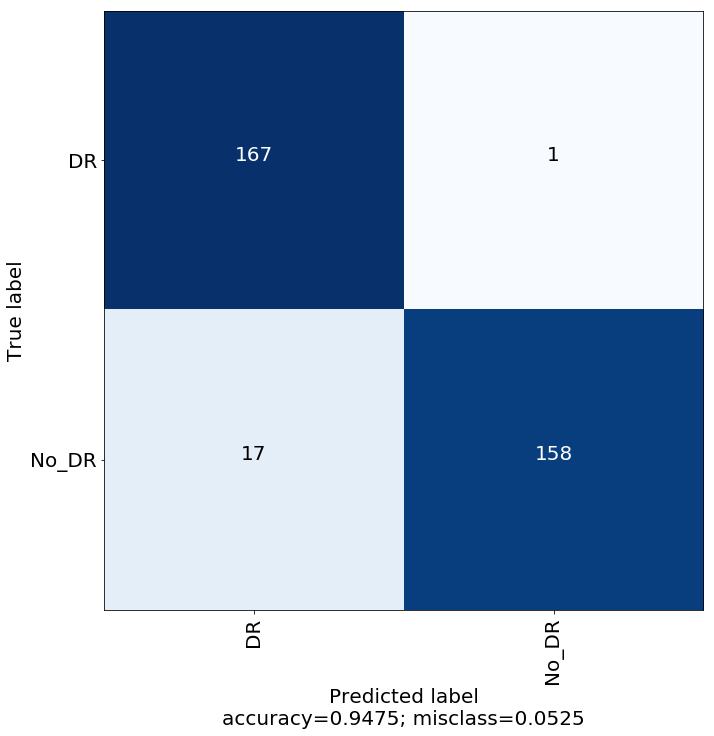

In [34]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[167   1]
 [ 17 158]]
              precision    recall  f1-score   support

          DR       0.91      0.99      0.95       168
       No_DR       0.99      0.90      0.95       175

    accuracy                           0.95       343
   macro avg       0.95      0.95      0.95       343
weighted avg       0.95      0.95      0.95       343



In [36]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.907608695652174
Specificity :  0.9937106918238994


In [37]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

343/343 [==============================] - 0s 104us/step
Precision =  0.9515382855357074
Recall =  0.9475218658892128
f1_score =  0.9474575894593005


In [38]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.948452380952381


In [39]:
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score, classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score


k_fold = KFold(n_splits=10, shuffle=True, random_state=5)

In [40]:
y_test = np.asarray(test_labels)
y_test = np.argmax(y_test, axis=1)

y_train = np.asarray(train_labels)
y_train = np.argmax(y_train, axis=1)

**BaggingClassifier**

In [41]:
clf = BaggingClassifier(RandomForestClassifier(), n_estimators = 300 )
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

Train accuracy 0.9717620481927711
Test accuracy 0.9591836734693877
AdaBoost Classifier test accuracies 0.9592
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       168
           1       0.97      0.95      0.96       175

    accuracy                           0.96       343
   macro avg       0.96      0.96      0.96       343
weighted avg       0.96      0.96      0.96       343

0.9591836734693877


**BaggingClassifier - KFold:10**

In [42]:
clf = BaggingClassifier(RandomForestClassifier(), n_estimators = 300 )
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("BaggingClassifier - Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 93.2689 and (STDEV 0.0323)
Best result for fold 0
Best accuracy is 1.0
Scores of all folds: [1.         0.97142857 0.91428571 0.94117647 0.88235294 0.91176471
 0.91176471 0.94117647 0.94117647 0.91176471]
BaggingClassifier - Test Accuracy on all folds: 0.93 (+/- 0.06)


**AdaBoostClassifier**

In [43]:
clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators = 300 )
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

Train accuracy 0.9996234939759037
Test accuracy 0.9329446064139941
AdaBoost Classifier test accuracies 0.9329
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       168
           1       0.94      0.93      0.93       175

    accuracy                           0.93       343
   macro avg       0.93      0.93      0.93       343
weighted avg       0.93      0.93      0.93       343

0.9329446064139941


**AdaBoostClassifier - KFold:10**

In [44]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("(AdaBoost Classifier) Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 91.8151 and (STDEV 0.0572)
Best result for fold 1
Best accuracy is 0.9714285714285714
Scores of all folds: [0.91428571 0.97142857 0.94285714 0.88235294 0.76470588 0.94117647
 0.97058824 0.94117647 0.91176471 0.94117647]
(AdaBoost Classifier) Test Accuracy on all folds: 0.92 (+/- 0.11)


**XGBClassifier**

In [45]:
clf = xgb.XGBClassifier()
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('XGB Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

Train accuracy 0.9789156626506024
Test accuracy 0.9591836734693877
XGB Classifier test accuracies 0.9592
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       168
           1       0.97      0.95      0.96       175

    accuracy                           0.96       343
   macro avg       0.96      0.96      0.96       343
weighted avg       0.96      0.96      0.96       343

0.9591836734693877


**XGBClassifier - KFold: 10**

In [46]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("XGB - Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 94.4370 and (STDEV 0.0515)
Best result for fold 0
Best accuracy is 1.0
Scores of all folds: [1.         1.         0.91428571 0.91176471 0.82352941 0.97058824
 0.97058824 0.91176471 0.97058824 0.97058824]
XGB - Test Accuracy on all folds: 0.94 (+/- 0.10)


**DecisionTreeClassifier**

In [47]:
clf = DecisionTreeClassifier()
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('DecisionTree Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

Train accuracy 0.9996234939759037
Test accuracy 0.8979591836734694
DecisionTree Classifier test accuracies 0.8980
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       168
           1       0.92      0.87      0.90       175

    accuracy                           0.90       343
   macro avg       0.90      0.90      0.90       343
weighted avg       0.90      0.90      0.90       343

0.8979591836734694


**DecisionTreeClassifier - KFold: 10**

In [48]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("DecisionTree - Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 89.7731 and (STDEV 0.0404)
Best result for fold 1
Best accuracy is 0.9428571428571428
Scores of all folds: [0.91428571 0.94285714 0.91428571 0.88235294 0.79411765 0.88235294
 0.94117647 0.91176471 0.88235294 0.91176471]
DecisionTree - Test Accuracy on all folds: 0.90 (+/- 0.08)


**RandomForestClassifier**

In [49]:
clf = RandomForestClassifier(n_estimators=5)
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('RandomForest Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

Train accuracy 0.9890813253012049
Test accuracy 0.9329446064139941
RandomForest Classifier test accuracies 0.9329
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       168
           1       0.95      0.91      0.93       175

    accuracy                           0.93       343
   macro avg       0.93      0.93      0.93       343
weighted avg       0.93      0.93      0.93       343

0.9329446064139941


**RandomForestClassifier - KFold: 10**

In [50]:
clf = RandomForestClassifier(n_estimators=5)
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, test_labels, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("(RandomForest) Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 90.3697 and (STDEV 0.0418)
Best result for fold 6
Best accuracy is 0.9705882352941176
Scores of all folds: [0.94285714 0.88571429 0.91428571 0.91176471 0.82352941 0.91176471
 0.97058824 0.94117647 0.88235294 0.85294118]
(RandomForest) Test Accuracy on all folds: 0.90 (+/- 0.08)


**LightGBM**

In [51]:
import lightgbm as lgb

lgbm=lgb.LGBMClassifier(n_estimators=1000, class_weight="balanced", reg_alpha=0.1, reg_lambda=0.1, learning_rate=0.001, num_leaves=400,
                        random_state=523, boosting='dart')

lgbm_scores=cross_val_score(lgbm,train_data, y_train, cv=10)
print(lgbm_scores)
print("Train accuracy mean and std %.2f" %np.mean(lgbm_scores),"+/- %.2f"%np.std(lgbm_scores))

[0.93258427 0.92883895 0.94360902 0.94736842 0.94716981 0.9245283
 0.96981132 0.92830189 0.92830189 0.73584906]
Train accuracy mean and std 0.92 +/- 0.06


In [56]:
lgbm.fit(train_data, y_train)
y_pred=lgbm.predict(test_data)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       168
           1       0.97      0.95      0.96       175

    accuracy                           0.96       343
   macro avg       0.96      0.96      0.96       343
weighted avg       0.96      0.96      0.96       343

0.9329446064139941


**LightGBM - KFold: 10**

In [53]:
lgbm_scores=cross_val_score(lgbm,test_data, y_test, cv=10)
print(lgbm_scores)
print("(LighGBM) Test accuracy on all folds mean and std %.2f" %np.mean(lgbm_scores),"+/- %.2f"%np.std(lgbm_scores))

[0.91428571 1.         0.85714286 0.91428571 0.97142857 0.94117647
 0.94117647 0.94117647 0.87878788 0.90909091]
(LighGBM) Test accuracy on all folds mean and std 0.93 +/- 0.04


In [54]:
scoring = 'accuracy'
scores = cross_val_score(lgbm, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("(LighGBM) Test Accuracy on all folds: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 92.9916 and (STDEV 0.0577)
Best result for fold 8
Best accuracy is 1.0
Scores of all folds: [0.94285714 0.97142857 0.91428571 0.85294118 0.82352941 0.88235294
 0.97058824 0.94117647 1.         1.        ]
(LighGBM) Test Accuracy on all folds: 0.93 (+/- 0.12)


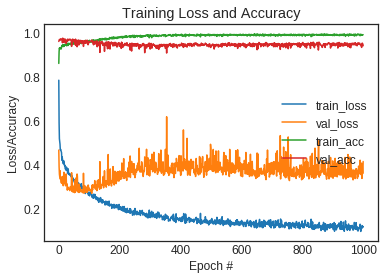

In [55]:
plt.rcParams.update({'font.size': 12})

import seaborn
plt.style.use('seaborn-white')

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")